## Pemodelan Menggunakan CNN

### Load Dataset

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [ ]:
data_dir = "sampah_classification/BurstNet"

In [3]:
print(os.listdir(data_dir))

['Kaca', 'Kardus', 'Kertas', 'Metal', 'Minyak', 'Organik', 'Pakaian', 'Plastik']


In [4]:
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"{folder_name}: {num_files} files")

Kaca: 2011 files
Kardus: 1515 files
Kertas: 1887 files
Metal: 1979 files
Minyak: 116 files
Organik: 1166 files
Pakaian: 5972 files
Plastik: 1075 files


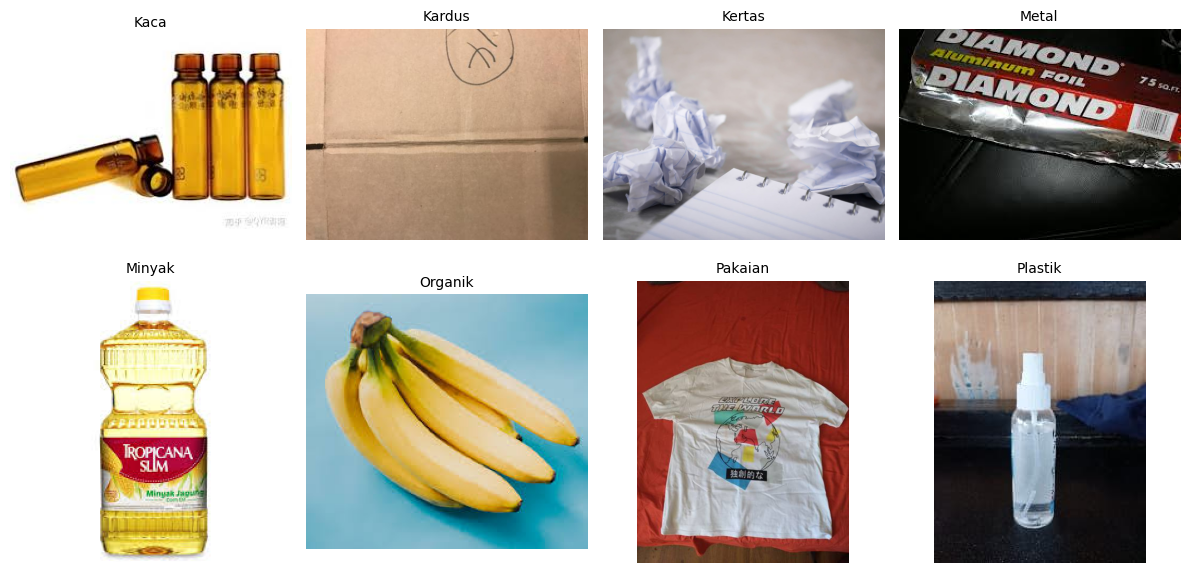

In [6]:
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
n_display = min(16, len(folders))
n_cols = 4
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for idx in range(n_display):
    folder = folders[idx]
    folder_path = os.path.join(data_dir, folder)
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    ax = axes[idx]
    if files:
        img_path = os.path.join(folder_path, files[0])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(folder, fontsize=10)
    ax.axis('off')

for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
df_images = pd.DataFrame([
    {'Image': img_file, 'Class': folder}
    for folder in folders
    for img_file in os.listdir(os.path.join(data_dir, folder))
    if os.path.isfile(os.path.join(data_dir, folder, img_file))
])
df_images.tail()

,Image,Class
15716,plastic95.jpg,Plastik
15717,plastic96.jpg,Plastik
15718,plastic97.jpg,Plastik
15719,plastic98.jpg,Plastik
15720,plastic99.jpg,Plastik


In [9]:
# Ambil 2000 data secara acak dari seluruh dataset
df_sampled = df_images.sample(n=2000, random_state=42) if len(df_images) > 2000 else df_images.copy()
print(f"Jumlah data yang diambil: {len(df_sampled)}")

Jumlah data yang diambil: 2000


In [11]:
print(df_sampled['Class'].value_counts())

Class
Pakaian    769
Kertas     258
Kaca       240
Metal      236
Kardus     198
Organik    155
Plastik    135
Minyak       9
Name: count, dtype: int64


### Split Data


In [7]:
from sklearn.model_selection import train_test_split
import os
from PIL import Image

In [15]:
train_val, df_test = train_test_split(
    df_images, test_size=0.15, stratify=df_images['Class'], random_state=42
)
df_train, df_val = train_test_split(
    train_val, test_size=0.1765, stratify=train_val['Class'], random_state=42
)  # 0.1765 x 0.85 ≈ 0.15

print(f"Train: {len(df_train)}")
print(f"Validation: {len(df_val)}")
print(f"Test: {len(df_test)}")

Train: 11003
Validation: 2359
Test: 2359


In [16]:
for df in [df_train, df_val, df_test]:
    df['filepath'] = df.apply(
        lambda row: os.path.join(data_dir, row['Class'], row['Image']),
        axis=1
    )

In [17]:
print("Cek apakah file benar-benar ada:")
print(df_train['filepath'].apply(os.path.exists).value_counts())

# Tampilkan contoh path
for i in range(5):
    path = df_train.iloc[i]['filepath']
    print(f"{i+1}. {path} -- Exists: {os.path.exists(path)}")

Cek apakah file benar-benar ada:
filepath
True    11003
Name: count, dtype: int64
1. C:/Users/bayyi/OneDrive/Documents/RESEARCH/sampah_classification/BurstNet\Kertas\R_4894.jpg -- Exists: True
2. C:/Users/bayyi/OneDrive/Documents/RESEARCH/sampah_classification/BurstNet\Pakaian\clothes2700.jpg -- Exists: True
3. C:/Users/bayyi/OneDrive/Documents/RESEARCH/sampah_classification/BurstNet\Pakaian\shoes964.jpg -- Exists: True
4. C:/Users/bayyi/OneDrive/Documents/RESEARCH/sampah_classification/BurstNet\Kaca\brown-glass138.jpg -- Exists: True
5. C:/Users/bayyi/OneDrive/Documents/RESEARCH/sampah_classification/BurstNet\Kaca\white-glass26.jpg -- Exists: True


In [18]:
def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except:
        return False

In [19]:
df_train = df_train[df_train['filepath'].apply(is_valid_image)]
df_val = df_val[df_val['filepath'].apply(is_valid_image)]
df_test = df_test[df_test['filepath'].apply(is_valid_image)]

In [20]:
print("Train:", len(df_train))
print("Val:", len(df_val))
print("Test:", len(df_test))

Train: 11002
Val: 2359
Test: 2359


In [21]:
df_train['filepath'].apply(os.path.exists).value_counts()

filepath
True    11002
Name: count, dtype: int64

#### Data Augmentasi

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
# Train
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',
    y_col='Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Validation
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepath',
    y_col='Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Test
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col='Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 11002 validated image filenames belonging to 8 classes.
Found 2359 validated image filenames belonging to 8 classes.
Found 2359 validated image filenames belonging to 8 classes.


In [26]:
print(df_train.columns)

Index(['Image', 'Class', 'filepath'], dtype='object')


### Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Activation

In [28]:
num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)

Jumlah kelas: 8


In [36]:
labels = train_generator.classes 
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9774342572850035, 1: 1.2974056603773585, 2: 1.0410673732021196, 3: 0.9929602888086643, 4: 17.190625, 5: 1.6853553921568627, 6: 0.3290071770334928, 7: 1.8263612217795484}


In [34]:
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40
335/344 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.4871 - loss: 1.4510

c:\Users\bayyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 136s 394ms/step - accuracy: 0.4889 - loss: 1.4459 - val_accuracy: 0.6172 - val_loss: 1.0755
Epoch 2/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 106s 308ms/step - accuracy: 0.6322 - loss: 1.0462 - val_accuracy: 0.6426 - val_loss: 1.0706
Epoch 3/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 147s 429ms/step - accuracy: 0.6683 - loss: 0.9409 - val_accuracy: 0.6901 - val_loss: 0.9004
Epoch 4/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 151s 438ms/step - accuracy: 0.6910 - loss: 0.8793 - val_accuracy: 0.6706 - val_loss: 0.9339
Epoch 5/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 151s 438ms/step - accuracy: 0.7183 - loss: 0.8079 - val_accuracy: 0.6999 - val_loss: 0.8696
Epoch 6/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 192s 559ms/step - accuracy: 0.7393 - loss: 0.7431 - val_accuracy: 0.7287 - val_loss: 0.8353
Epoch 7/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 307s 891ms/step - accuracy: 0.7741 - loss: 0.6601 - val_accuracy: 0.7262 - val_loss: 0.8000
Epoch 8/40
344/344 ━━━━━━━━━━━━━━━━━━━━ 156s 453ms/step - accuracy: 0.7858 - loss: 0.61

### Evaluation

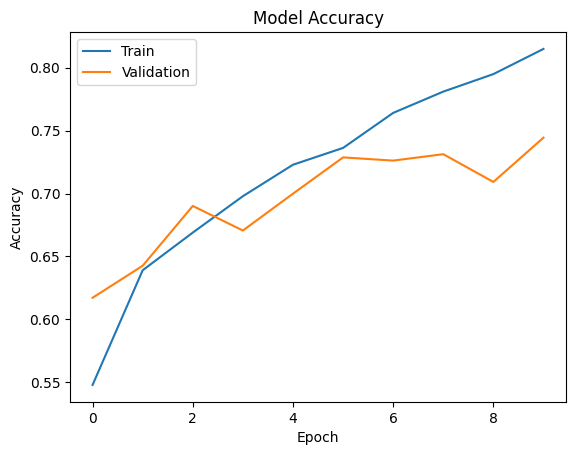

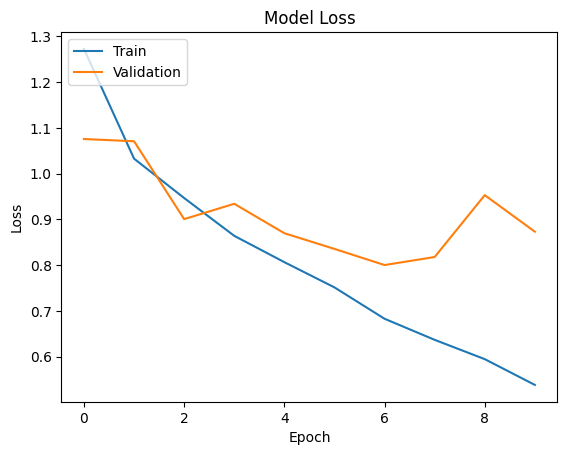

In [39]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [40]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

c:\Users\bayyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 39s 528ms/step - accuracy: 0.7260 - loss: 0.7944
Test accuracy: 0.7274268865585327


In [41]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi di test set
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Label nama kelas
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_labels))


74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step
              precision    recall  f1-score   support

        Kaca       0.61      0.80      0.69       302
      Kardus       0.75      0.66      0.70       227
      Kertas       0.70      0.49      0.58       283
       Metal       0.66      0.49      0.56       297
      Minyak       0.43      0.33      0.38        18
     Organik       0.67      0.70      0.68       175
     Pakaian       0.85      0.92      0.88       896
     Plastik       0.50      0.53      0.52       161

    accuracy                           0.73      2359
   macro avg       0.65      0.62      0.62      2359
weighted avg       0.73      0.73      0.72      2359

